# C S 329E HW 12

# Association Analysis - Frequent Itemsets and Rule Generation

### Fayed Nassor
### Mohamad Minoneshan

Association analysis extracts hidden relationships from large datasets. We'll be using one of the most commonly used algorithms for association rule mining: Apriori.

For this assignment you will be using the `MLxtend` library. The documentation for this library is available [here](http://rasbt.github.io/mlxtend/).

You will need to install the `MLxtend` library. See the setup guide [here](http://rasbt.github.io/mlxtend/installation/).

## Bread Basket Data

The dataset belongs to "The Bread Basket" a bakery located in Edinburgh. The dataset has 21293 entires, over 6000 transactions and 4 columns:

  - **Date**: Categorical variable that tells us the date of the transactions (YYYY-MM-DD format).
  - **Time**: Categorical variable that tells us the time of the transactions (HH:MM:SS format). 
  - **Transaction**: Quantitative variable that allows us to differentiate the transactions. The rows that share the same value in this field belong to the same transaction, that's why the data set has less transactions than observations.
  - **Item**: Categorical variable with the products.

You'll need to clean up the input data and convert it to a transaction list with itemsets, and find itemsets that occur more than the `min_sup` threshold. Based on these frequent itemsets you'll find association rules that have confidence above the `min_conf` threshold.

In [ ]:
!pip install MLxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Do not modify import block, all necessary imports are included

# Our regular libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# This is for our association analysis 
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Q1 - Data Analysis
The data has been delivered to us in a format that doesn't match the transaction format that we used in the lecture to create frequent itemsets, but instead in a one item per line format that contains a transaction ID.  Let's visualize what kind of data we have.

Load the `BreadBasket.csv` file into a dataframe and:

  1. Plot the most frequent 20 items in a a histogram.  You may use panda's `value_counts` with the [matplotlib](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/categorical_variables.html) documentation on how to create a histogram with categorical data. Make sure your axis is readable and labeled.  I used a figsize of (15,5).
  2. Calculate how many unique items are in the dataset
  3. Calculate how many transactions there are in the dataset 
  
As you may notice there is an item with the name `NONE` ... remove all of those before you answer the above questions.

In [ ]:
df_breadbasket = pd.read_csv('https://gist.githubusercontent.com/GregKuhlmann/1605ab44ac19c7edea5501d7a2dcc122/raw/1ad3ac582646a5389ea022e7d0e8e43686f3ffec/BreadBasket.csv')

# Removing rows with Item == 'NONE' 
df_breadbasket = df_breadbasket[df_breadbasket['Item'] != 'NONE'].reset_index(drop=True)

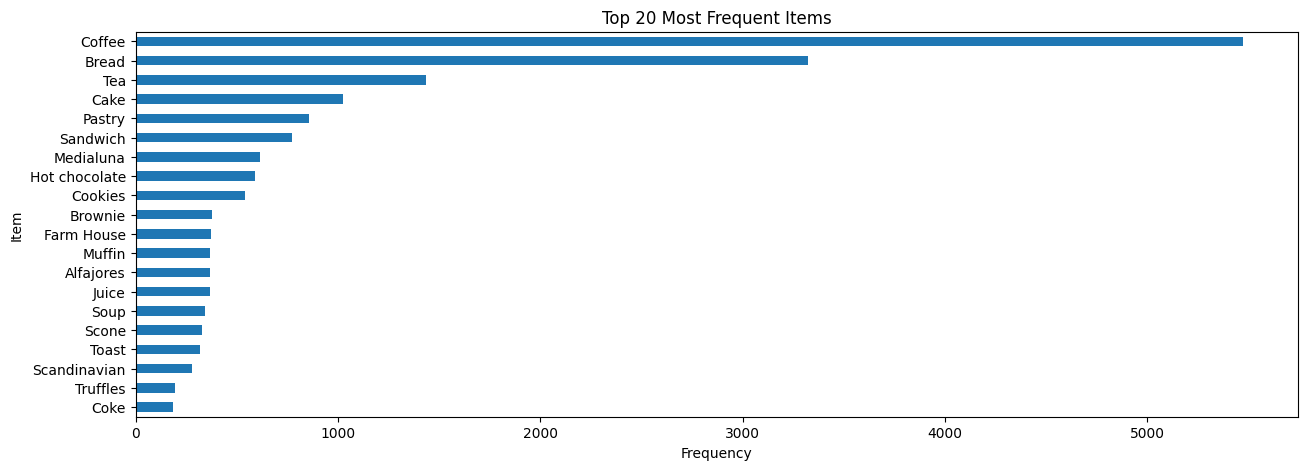

In [ ]:
# Histogram for the most 20 frequent items

top_20 = df_breadbasket['Item'].value_counts().head(20)
fig, ax = plt.subplots(figsize=(15, 5))
top_20.plot(kind='barh', ax=ax)
# Set labels and titles
ax.set_xlabel('Frequency')
ax.set_ylabel('Item')
ax.set_title('Top 20 Most Frequent Items')

# Invert the y-axis to have the highest frequency item on top
ax.invert_yaxis()

# Display the plot
plt.show()

In [ ]:
# The number of unique items

N_unique_items = df_breadbasket['Item'].nunique()
print('The number of unique items is',N_unique_items)

The number of unique items is 94


In [ ]:
# The number of Transactions

N_transactions = df_breadbasket['Transaction'].nunique()
print('The number of Transactions in the data is',N_transactions)

The number of Transactions in the data is 9465


In [ ]:
df_breadbasket.tail()

,Date,Time,Transaction,Item
20502,2017-04-09,14:32:58,9682,Coffee
20503,2017-04-09,14:32:58,9682,Tea
20504,2017-04-09,14:57:06,9683,Coffee
20505,2017-04-09,14:57:06,9683,Pastry
20506,2017-04-09,15:04:24,9684,Smoothies


## Q2 - Data Prep: Convert to One Hot Encoded Transactions
Convert the data to a transaction array.  The transaction array is a list of lists, for example:

```
dataset = [['Milk', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Dill', 'Onion', 'Nutmeg', 'Kidney Beans', 'Eggs', 'Yogurt'],
           ['Milk', 'Apple', 'Kidney Beans', 'Eggs'],
           ['Milk', 'Unicorn', 'Corn', 'Kidney Beans', 'Yogurt'],
           ['Corn', 'Onion', 'Onion', 'Kidney Beans', 'Ice cream', 'Eggs']]
```

Pandas has a special function called `groupby` which we can use to collate all of the items with the same transaction ID into a list.  Here is a nice [tutorial](https://realpython.com/pandas-groupby/). You can get the list of lists of transactions by grouping the data by "Transaction" column, referencing the "Item" column, then applying a list.  This gives you a series with the transaction ID equal to the index, but the [TransactionEncoder](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) to prep the data for our library just wants the values of that series. 

There are other methods you may use to create the transaction array using the `BreadBasked.csv` data with the `NONE` values filtered out, but they might require a little more code than the methodology suggested above.

Use the `mlxtend` TransactionEncoder library to encode the transaction array in a one hot encoding. Create the one hot encoding using the TransactionEncoder, and check it was done properly by looking at the first 4 transactions using the `inverse_transform`. Finish off the data prep for the frequent itemset generation by converting the transactions back to a dataframe using the [documentation](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) as a reference. 

In [ ]:
# First Step: Using groupby to collate the items with same transaction ID into a list
listed_items = df_breadbasket.groupby('Transaction')['Item'].agg(list).reset_index()
listed_items.head()

,Transaction,Item
0,1,[Bread]
1,2,"[Scandinavian, Scandinavian]"
2,3,"[Hot chocolate, Jam, Cookies]"
3,4,[Muffin]
4,5,"[Coffee, Pastry, Bread]"


In [ ]:
# Step 2: using mlxtend to encode the Item Column in listed_items in a one_hot encoding
encoder = TransactionEncoder()
one_hot  = encoder.fit(listed_items['Item']).transform(listed_items['Item'])

# Step 3: using inverse_transform to check the first 4 transactions whether our encoding is being done correct
decoded_transactions = encoder.inverse_transform(one_hot[:4])
print(decoded_transactions)

[['Bread'], ['Scandinavian'], ['Cookies', 'Hot chocolate', 'Jam'], ['Muffin']]


In [ ]:
# Step 4: Converting back the transactions back to a dataframe
encoded_df = pd.DataFrame(one_hot, columns=encoder.columns_)
encoded_df.head()

,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Q3 - Create Frequent Itemsets 
Using the [apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) method, create a frequent itemset that we can use to create rules with.  Unlike in the lecture notes, this implementation doesn't use an integer _minsup_ , it refers to support of the percent of the transactions that it has to contain to be frequent.  Since we have 9465 transactions, if we want _minsup_ to be 100, then the library expects a `min_support` fraction of $\frac{100}{9465}$. Find all the frequent item sets with _minsup_ set to 20. Show the last 15 frequent item sets displaying the item names (not the item column indices). 

In [ ]:
# Creating a frequent itemset using apriori method, with mindsup = 20
minsup = 20
min_support = minsup / len(encoded_df)
frequent_itemsets = apriori(encoded_df, min_support= min_support, use_colnames=True)
frequent_itemsets.head()

,support,itemsets
0,0.004543,(Afternoon with the baker)
1,0.036344,(Alfajores)
2,0.004015,(Art Tray)
3,0.016059,(Baguette)
4,0.005071,(Bakewell)


In [ ]:
# Showing the last 15 frequent item sets displaying the item names

print('The last 15 frequent itemsets are as following:\n',frequent_itemsets.tail(15)['itemsets'].to_string(index=False))

The last 15 frequent itemsets are as following:
             (Coffee, Cookies, Tea)
(Coffee, Hot chocolate, Medialuna)
   (Pastry, Hot chocolate, Coffee)
 (Coffee, Hot chocolate, Sandwich)
         (Juice, Coffee, Sandwich)
       (Pastry, Coffee, Medialuna)
          (Coffee, Tea, Medialuna)
             (Coffee, Muffin, Tea)
             (Pastry, Coffee, Tea)
          (Coffee, Soup, Sandwich)
           (Coffee, Tea, Sandwich)
      (Coffee, Truffles, Sandwich)
              (Scone, Coffee, Tea)
               (Coffee, Soup, Tea)
              (Coffee, Tea, Toast)


## Q4 - Generate Strong Rules
Use the [association_rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) to calculate rules with a confidence level of 0.5 for the frequent itemsets you generated in Q3.

You should notice something in common with all of the rules.  Are these rules helpful for our bakery? 

In [ ]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5).reset_index(drop=True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648
1,(Art Tray),(Coffee),0.004015,0.478394,0.002747,0.684211,1.430224,0.000826,1.651752
2,(Bakewell),(Coffee),0.005071,0.478394,0.003064,0.604167,1.262906,0.000638,1.317741
3,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664
4,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174
5,(Extra Salami or Feta),(Coffee),0.004015,0.478394,0.003275,0.815789,1.705267,0.001355,2.831575
6,(Frittata),(Coffee),0.008558,0.478394,0.004543,0.530864,1.109680,0.000449,1.111844
7,(Hearty & Seasonal),(Coffee),0.010565,0.478394,0.005705,0.540000,1.128777,0.000651,1.133926
8,(Hot chocolate),(Coffee),0.058320,0.478394,0.029583,0.507246,1.060311,0.001683,1.058553
9,(Jammie Dodgers),(Coffee),0.013207,0.478394,0.006656,0.504000,1.053525,0.000338,1.051625


➡️ _insight about what all the rules have in common here and if that is useful for the bakery_ ⬅️
All the rules have a consequent of cofee which is not very useful, the bakery would benefit from insight beyond this

## Q5 - Generate Strong Rules (pt 2)
While reading the documentation for creating [association rules](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/) you notice that there are many other metrics to choose from.  Try creating rules with the following:
   - lift > 3
   - leverage > 0.004
   - conviction > 1.2

In [ ]:
liftAbove3 = association_rules(frequent_itemsets, metric="lift", min_threshold=3)
liftAbove3

In [ ]:
leverageAbove = rules[rules['leverage'] > 0.004]
leverageAbove


In [ ]:
convictionAbove = rules[rules['conviction'] > 1.2]
convictionAbove

## Q6 - Create Actionable Business Insight
Pretend you are a consultant contracted to work for this bakery and come up with a promotion to increase sales. You have performed the above analysis, now how would you suggest the bakery use this data?

Be creative.  It could be in training employees, programming the cash register, advertising specials, etc.. Describe your approach and why you think the data supports it.  

➡️ _put your insight here_ ⬅️
With this in mind it is important to note that the prevalence of cofee is very popular, spending time marketing it would be a waste of efforts as it already sees sucess, to improve overall sales, the shop should put similarly sold items in the same area, so often sandwiches and soup are accompained with juice or water, so having it neraby as well as the employees offer it as an option should increase likely sales. The same such as cookies or cake should all be grouped together also.